# Installation instructions

## Using conda

We recommend using [conda](https://docs.conda.io/en/latest/) for installing pySCTransform.

```bash
conda create -n pysct leidenalg scanpy jupyterlab
conda activate pysct
pip install git+https://github.com/saketkc/pysctransform.git
```

If you would like to use [glmGamPoi]() for estimation, `rpy2' and `glmGamPoi` need to be installed as well:

```bash
conda create -n pysct leidenalg scanpy jupyterlab rpy2 bioconductor-glmgampoi
conda activate pysct
pip install git+https://github.com/saketkc/pysctransform.git@glmgp

```

## Using pip/venv

If you do not want to install conda, you can install using [venv]():

```bash
python3 -m venv pysct_venv
source pysct_venv/bin/activate
pip install scanpy leidenalg
pip install git+https://github.com/saketkc/pysctransform.git
```


In [1]:
%pylab inline
import scanpy as sc
import pandas as pd
from pysctransform.pysctransform import vst
from pysctransform.plotting import plot_fit, plot_residual_var, compare_with_sct

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!wget --content-disposition -c https://www.dropbox.com/s/33tjdp0vvhh8yx7/pysct_test_data.zip && unzip pysct_test_data.zip

In [2]:
pbmc3k = sc.read_h5ad("./pysct_test_data/pbmc3k.h5ad")

# PBMC3k - Using glmgp

There are multiple methods supported for estimating $\theta$ in pySCTransform. Invoking `method='theta_ml` only requires Python3 to run, while `method="glmgp"` or `method="glmgp_offset"` requires [rpy2](https://pypi.org/project/rpy2/) and 
[glmGamPoi](https://bioconductor.org/packages/release/bioc/html/glmGamPoi.html).

The main methof of interest is `vst` which performs regularized negative binomial regression and returns
residuals. Input to `vst` is a gene by cell matrix.

In [3]:
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    method="glmgp",
    n_cells=None,
    n_genes=2000,
)

## Plot model and regularized parameters

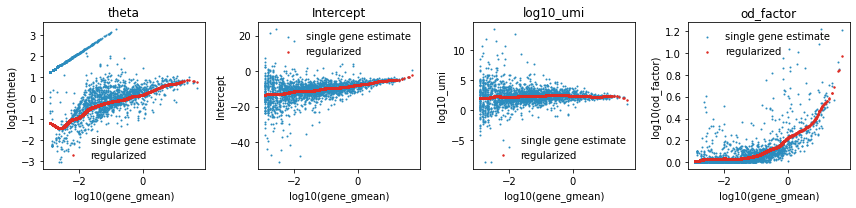

In [4]:
_ = plot_fit(vst_out_3k)

## Plot residual variance with respect to gene mean

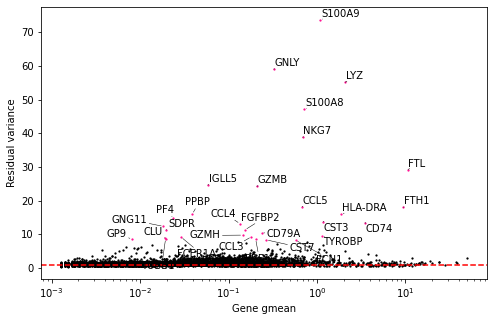

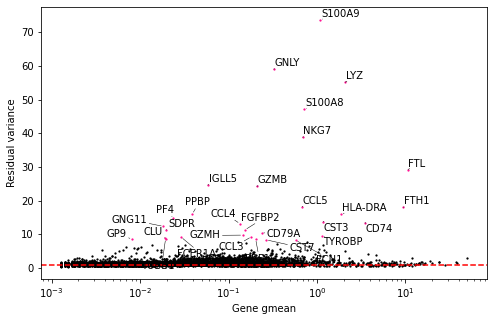

In [5]:
plot_residual_var(vst_out_3k)

## Compare with R SCTransform

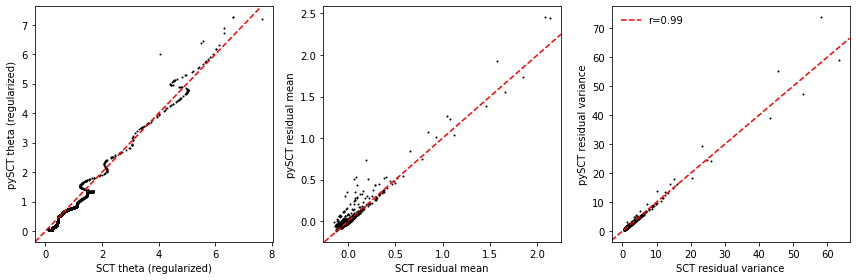

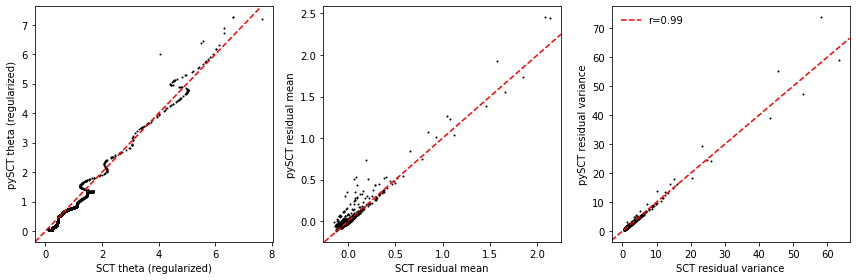

In [8]:
compare_with_sct(
    vst_out_3k,
    sct_modelparsfit_file="./pysct_test_data/pbmc3k/pbmc3k_thetaml_model_pars_fit.csv",
    sct_geneattr_file="./pysct_test_data/pbmc3k/pbmc3k_thetaml_gene_attr.csv",
)

# PBMC3k - Using theta_ml



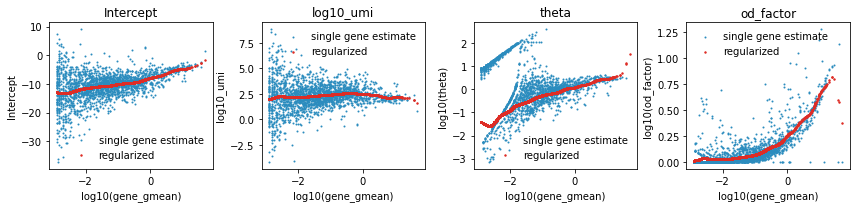

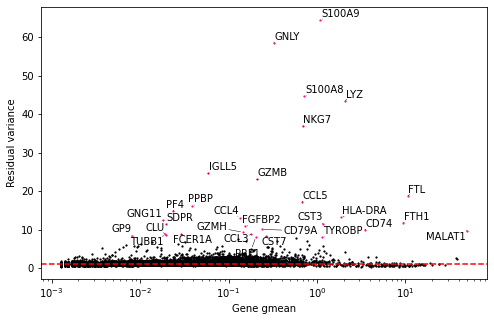

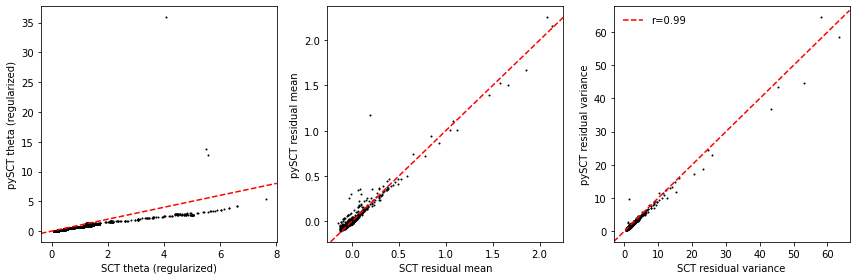

In [12]:
### Input is gene x cell
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    method="theta_ml",
    n_cells=5000,
    n_genes=2000,
)

_ = plot_fit(vst_out_3k)
_ = plot_residual_var(vst_out_3k)
_ = compare_with_sct(
    vst_out_3k,
    sct_modelparsfit_file="./pysct_test_data/pbmc3k/pbmc3k_thetaml_model_pars_fit.csv",
    sct_geneattr_file="./pysct_test_data/pbmc3k/pbmc3k_thetaml_gene_attr.csv",
)

# PBMC3k - Using fix-slope

Using `method="fix-slope"` fixes the slope to 1 and only intercept is estimated. Intercept and $\theta$ are still regularized.
This requires `rpy2` and `glmGamPoi` to be installed. 

Alternatively, this can be invoked using `SCTransform()` method with `vst_flavor='v2'`.



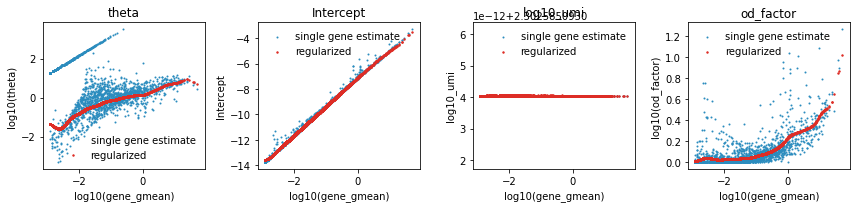

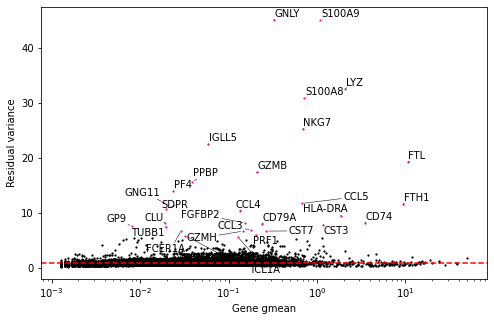

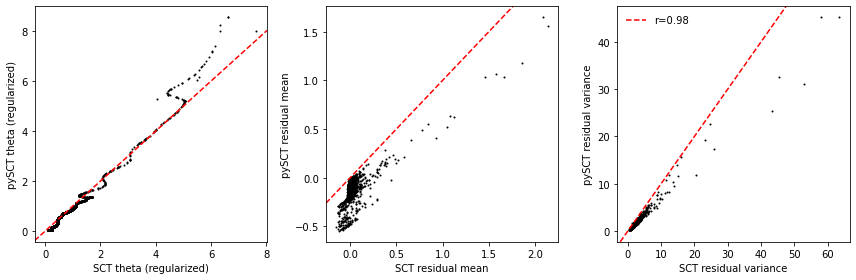

In [14]:
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    method="fix-slope",
    n_cells=5000,
    n_genes=2000,
)

_ = plot_fit(vst_out_3k)
_ = plot_residual_var(vst_out_3k)
_ = compare_with_sct(
    vst_out_3k,
    sct_modelparsfit_file="./pysct_test_data/pbmc3k/pbmc3k_thetaml_model_pars_fit.csv",
    sct_geneattr_file="./pysct_test_data/pbmc3k/pbmc3k_thetaml_gene_attr.csv",
)

# UMAPs

In [15]:
%%capture

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

adata = sc.read_h5ad("./pysct_test_data/pbmc3k.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
_ = sc.pl.umap(adata, color=["leiden"], legend_loc="on data", ax=ax1, show=False)


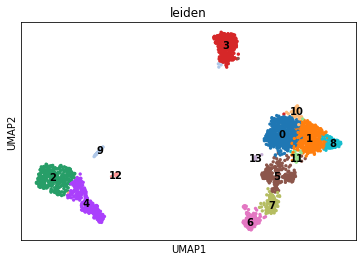

In [16]:
gene_attr = vst_out_3k["gene_attr"]
gene_attr = gene_attr.sort_values(by=["residual_variance"], ascending=False)
highly_variable = gene_attr.index[:3000].tolist()
clip_range = [-np.sqrt(pbmc3k.shape[0]/30), 
              np.sqrt(pbmc3k.shape[0]/30)]

residuals = vst_out_3k["residuals"].T[highly_variable]
residuals = np.clip(residuals, clip_range[0], clip_range[1])
pbmc3k.obsm["pearson_residuals_thetaml"] = residuals

X_pca = sc.pp.pca(pbmc3k.obsm["pearson_residuals_thetaml"])
pbmc3k.obsm["X_pca_thetaml"] = X_pca





sc.pp.neighbors(pbmc3k, use_rep="X_pca_thetaml")
sc.tl.umap(pbmc3k, min_dist=0.3)
sc.tl.leiden(pbmc3k)
sc.pl.umap(pbmc3k, color=["leiden"], legend_loc="on data",show=True)
_ = sc.pl.umap(pbmc3k, color=["leiden"], legend_loc="on data", ax=ax2, show=False)


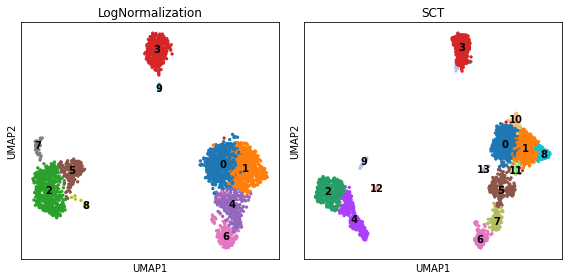

In [17]:
_ = ax1.set_title("LogNormalization")
_ = ax2.set_title("SCT")
fig.tight_layout()
fig
